In [1]:
# load  the model
# load  the dataloaders
# see what the model is and how the model is being used

In [2]:
import sys
import os

# Add project root (one directory up from notebooks)
sys.path.append(os.path.abspath('..'))


In [3]:
import torch


# model related
from models.fff_model import resnet, MLP, brazy_encoder, brazy_decoder, cond_conv_encoder, cond_conv_decoder, FreeFormFlow, condFreeFormFlow, ImprovedCNN
from models.architectures_fff import BrazyConfig, get_encoder_and_decoder

# model training related
from models.feature_extractor_creator import train_feature_extractor

#data related
from data.dataloaders_related import get_mnist_dataloaders

# plotting related
from utils.plotting import  five_samples_same_model_during_training


# trainer
from training.trainer import train_model_mnist, test_model

# 
import tqdm
from typing import Literal
from dataclasses import dataclass
from typing import Literal, Union, Tuple, Any

In [4]:
device= 'cpu'#"cuda" if torch.cuda.is_available() else "cpu"
print(device)

pixelwidth = 28

cpu


In [5]:
# mlp_cfg = MLPConfig(pixelwidth=28, fff_dim=128, fff_layers=3)
# resnet_cfg = ResNetConfig(pixelwidth=28, fff_dim=128, fff_layers=2, fff_resnet_blocks=4)
brazy_cfg = BrazyConfig(
    fff_c_small = 32,
    fff_f1_dim = 256,
    fff_f2_dim = 512,
    third_convolutional_layer = True,
    fff_batchnorm = False,
    fff_dropout = 0.1
)

encoder, decoder = get_encoder_and_decoder("brazy", brazy_cfg, device="cuda")
# get the model
fours_fff = FreeFormFlow(encoder, decoder, device=device, data_dims=pixelwidth**2).to(device)
fours_fff

FreeFormFlow(
  (encoder): brazy_encoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=6272, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (latent): Linear(in_features=512, out_features=784, bias=True)
    (batchnorm1): Identity()
    (batchnorm2): Identity()
  )
  (decoder): brazy_decoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=784, out_features=512, bias=True)
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc_to_conv): Linear(in_features=256, out_features=6272, bias=True)
    (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3,

### Training some feature extractors

In [6]:
# Hyperparameters
batch_size_feat_extractor = 64
learning_rate_feat_extractor= 0.001
epochs_feat_extractor = 5

# DataLoaders
train_loader, test_loader = get_mnist_dataloaders(batchsize=batch_size_feat_extractor, pixelwidth=28, digit=4)
zero_one_train_loader, zero_one_test_loader = get_mnist_dataloaders(batchsize=batch_size_feat_extractor, pixelwidth=28, digit=4, zero_one_range=True)

# Train both models
fid_feature_extractor = train_feature_extractor(
    ImprovedCNN, train_loader, device, learning_rate_feat_extractor, epochs_feat_extractor
)

zero_one_fid_feature_extractor = train_feature_extractor(
    ImprovedCNN, zero_one_train_loader, device, learning_rate_feat_extractor, epochs_feat_extractor
)

# Evaluate the model on test data
test_model(fid_feature_extractor, test_loader)
test_model(zero_one_fid_feature_extractor, zero_one_test_loader)

Test Accuracy: 100.00%
Test Accuracy: 100.00%


### Training the FFF model

In [ ]:
# code to fix: fix the check_acfff_classification_quality thingy (for the time being I have set it to False.)

In [8]:
# train the model
fours_fff, fours_fff_metrics, fours_fff_snapshots = train_model_mnist(fours_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=10,
                                                    lr=0.0008,
                                                    batchsize=500,
                                                    beta_r=1.,
                                                    fid_feature_extractor=fid_feature_extractor,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=True,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    zero_one_range=False,
                                                    check_acfff_classification_quality=False)

In [9]:
import matplotlib.pyplot  as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import LogLocator
import numpy as np

In [ ]:
five_samples_same_model_during_training(fours_fff_snapshots, n_epochs=1000)#, save_path="best_fours_samples.png")

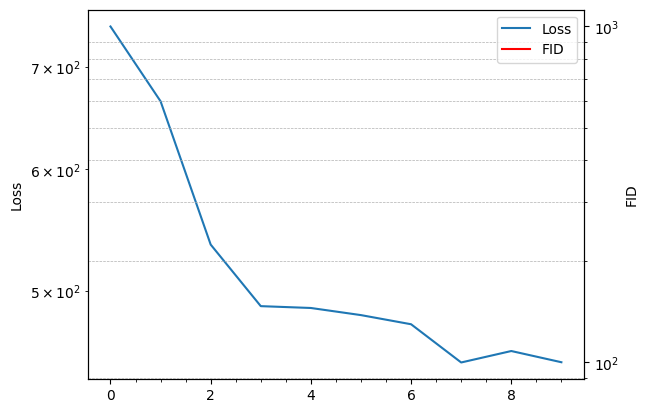

In [11]:
line1 = plt.plot(fours_fff_metrics["loss"], label="Loss")[0]
plt.yscale("log")
plt.ylabel("Loss")
ax = plt.twinx()
ax.set_yscale("log")
line2 = ax.plot(fours_fff_metrics["fid"][0], fours_fff_metrics["fid"][1], color="red", label="FID")[0]
ax.set_ylabel("FID")
plt.xlabel("Epochs")

lines = [line1,line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels)

ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=10))  # Minor ticks

plt.grid(plt.grid(which='both', linestyle='--', linewidth=0.5))

ax.minorticks_on()